In [1]:
import pandas as pd
from pandas_datareader import data as pdr
from datetime import date
from datetime import datetime
import yfinance as yf
yf.pdr_override()
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def SaveData(df, filename):
    df.to_csv(r'data/'+filename+'.csv')
    
def GetData(ticker_list, start_date, end_date):
    print(ticker_list)
    df=[]
    for ticker in ticker_list:
        #print(ticker)
        data = pdr.get_data_yahoo(ticker, start=start_date, end=end_date, progress=False)
        data['Symbol'] = ticker 
        df.append(data)
    print("Data Download Completed")
    return df

In [3]:
# Tickers list to download
ticker_list=['NIO','AAPL', 'V', 'MSFT', 'BAC', 'JPM', 'NFLX']

# Dates
today = date.today()
start_date = '2020-01-02'
end_date = today

# Get the Data
df = GetData(ticker_list, start_date, end_date)
df = pd.concat(df)
df = df.reset_index()
df = df[['Date', 'Adj Close', 'Symbol']]
stocks = df.pivot('Date','Symbol','Adj Close').reset_index()
#SaveData(stocks,str(start_date)+'|'+str(end_date))

['NIO', 'AAPL', 'V', 'MSFT', 'BAC', 'JPM', 'NFLX']
Data Download Completed


In [4]:
stocks

Symbol,Date,AAPL,BAC,JPM,MSFT,NFLX,NIO,V
0,2020-01-02,73.840042,34.709141,136.145889,158.936279,329.809998,3.720000,189.950775
1,2020-01-03,73.122154,33.988472,134.349243,156.957260,325.899994,3.830000,188.440079
2,2020-01-06,73.704819,33.939774,134.242432,157.362961,335.829987,3.680000,188.032593
3,2020-01-07,73.358185,33.715782,131.960220,155.928177,330.750000,3.240000,187.535660
4,2020-01-08,74.538239,34.056641,132.989639,158.411835,339.260010,3.390000,190.745880
...,...,...,...,...,...,...,...,...
231,2020-12-01,122.720001,28.512293,119.739998,216.210007,504.579987,45.360001,211.199997
232,2020-12-02,123.080002,28.880001,122.040001,215.369995,503.380005,47.980000,210.179993
233,2020-12-03,122.940002,28.910000,121.239998,214.240005,497.519989,45.349998,208.050003
234,2020-12-04,122.250000,29.290001,122.339996,214.360001,498.309998,43.040001,212.679993


In [5]:
# Calculate daily log returns
daily_returns = np.log(stocks[ticker_list]/stocks[ticker_list].shift(-1))
daily_returns.insert(0, 'Date', stocks['Date'])

# Calculate daily standard deviation of returns
daily_std = np.std(daily_returns)

# Annualized daily standard deviation
std = daily_std * 252 ** 0.5

# Computing weekly volatility for log returns (90% sure it is wrong)
weekly_volatility = daily_returns.rolling(5).std()

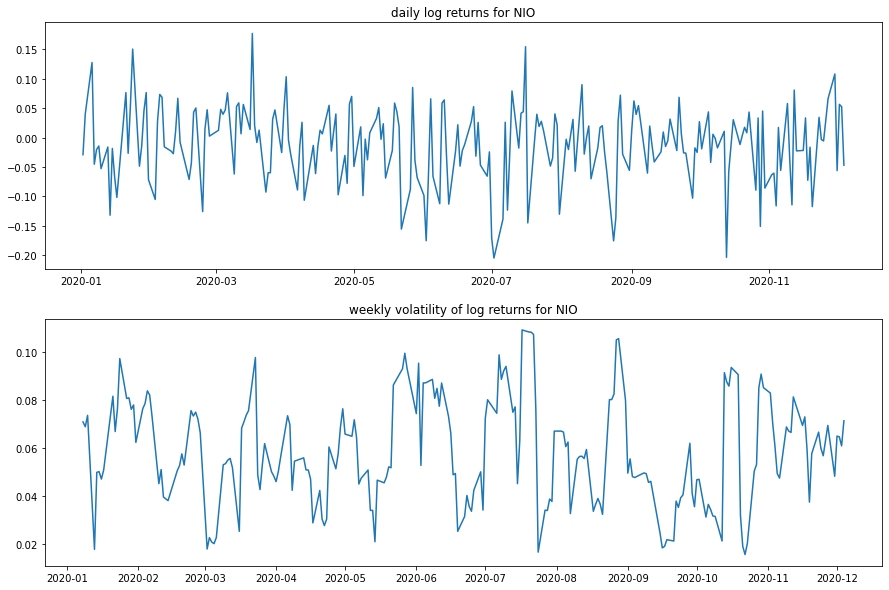

In [6]:
fig, ax = plt.subplots(2,1, figsize=(15,10))

ax[0].set_title('daily log returns for NIO')
ax[0].plot(daily_returns['Date'], daily_returns['NIO'])

ax[1].set_title('weekly volatility of log returns for NIO')
ax[1].plot(daily_returns['Date'], weekly_volatility['NIO'])

plt.show()

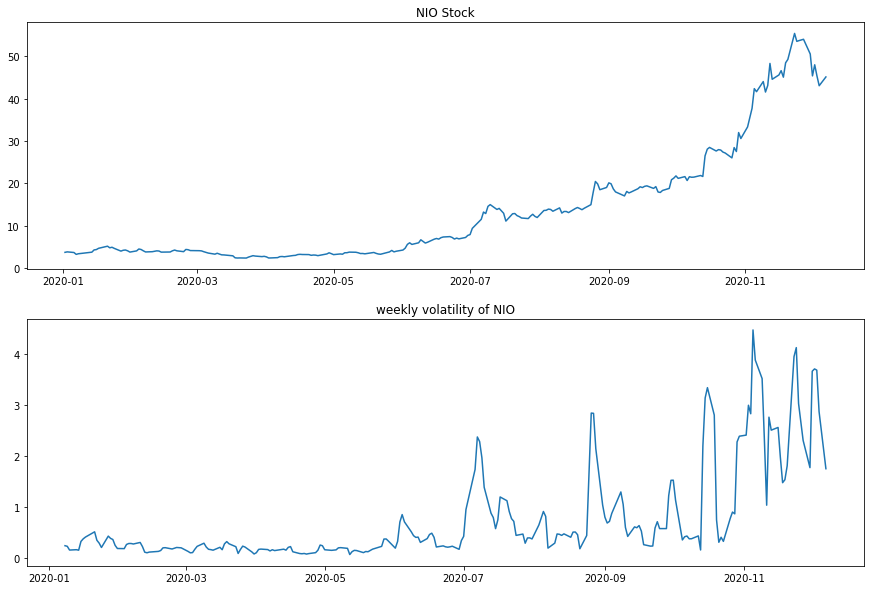

In [7]:
# Computing weekly volatility for the stocks
stocks_weekly_volatility = stocks.rolling(5).std()

fig, ax = plt.subplots(2,1, figsize=(15,10))

ax[0].set_title('NIO Stock')
ax[0].plot(stocks['Date'], stocks['NIO'])

ax[1].set_title('weekly volatility of NIO')
ax[1].plot(stocks['Date'], stocks_weekly_volatility['NIO'])

plt.show()

In [8]:
from arch import arch_model
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

# First model : GARCH on log daily returns for NIO
returns = daily_returns[['Date','NIO']].dropna()

# AR1
ar_res = AutoReg(returns['NIO'], lags=[1], old_names=True).fit()
print(ar_res.summary())

#mod = arch_model(returns['NIO'], vol='garch', p=1, o=0, q=1, rescale=True)
#res = mod.fit()
#print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                    NIO   No. Observations:                  235
Model:                     AutoReg(1)   Log Likelihood                 312.787
Method:               Conditional MLE   S.D. of innovations              0.064
Date:                Tue, 08 Dec 2020   AIC                             -5.486
Time:                        18:56:45   BIC                             -5.441
Sample:                             1   HQIC                            -5.468
                                  235                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0095      0.004     -2.247      0.025      -0.018      -0.001
NIO.L1         0.1029      0.065      1.581      0.114      -0.025       0.230
                                    Roots           

In [9]:
# ARMA(1,1) on log returns
arma_res = ARIMA(returns['NIO'], order=(1,0,1)).fit()
print(arma_res.summary())

# GARCH(1,1) on residuals
garch_res = arch_model(arma_res.resid, vol='garch', p=1, o=0, q=1, rescale=False).fit(update_freq=5)
print(garch_res.summary())

                               SARIMAX Results                                
Dep. Variable:                    NIO   No. Observations:                  235
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 318.461
Date:                Tue, 08 Dec 2020   AIC                           -628.922
Time:                        18:56:45   BIC                           -615.084
Sample:                             0   HQIC                          -623.343
                                - 235                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0106      0.005     -2.336      0.019      -0.019      -0.002
ar.L1         -0.7975      0.087     -9.143      0.000      -0.968      -0.627
ma.L1          0.9259      0.056     16.553      0.0

---

Pytrends data:

In [10]:
from pytrends.request import TrendReq
from pytrends import dailydata

import time

def GetTrends(keywords, start_date, end_date):
    """
    return the Google trends data (weekly and daily)
    
    :param keywords: the list of the keywords to search data for
    :param start_date: string of start_date. (Y-M-D format)
    :param end_date: string of end_date. (Y-M-D format)
    """
    
    startTime = time.time()
    
    
    timeframe = start_date +' '+ end_date
    
    
    start_date = datetime.date(datetime.strptime(start_date,"%Y-%m-%d"))
    end_date = datetime.date(datetime.strptime(end_date,"%Y-%m-%d"))

    start_year, start_month = start_date.year, start_date.month
    stop_year, stop_month = end_date.year, end_date.month
    
    # Connect to google trends
    # hl: host language (English)
    # timezone offset=360 (US CST)
    pytrends = TrendReq(hl='en-US', tz=360)

    #keywords list kw_list

    weekly_dataset = []
    
    daily_data = pd.DataFrame(columns=keywords)
    weekly_data = pd.DataFrame(columns=keywords)

    for keyword in keywords:
        
        #build payload for pytrends
        pytrends.build_payload(
        kw_list=[keyword],
        timeframe = timeframe)
        
        #get weekly data
        tmp_data = pytrends.interest_over_time()
        
        if not tmp_data.empty:
            weekly_data[keyword] = tmp_data[keyword]
            
            
        #get daily data
        col_name = keyword+"_unscaled"
        tmp_data = dailydata.get_daily_data(keyword,
                                              start_year,
                                              start_month,
                                              stop_year,
                                              stop_month,
                                              geo='US',
                                              verbose=False)[col_name]
        
        if not tmp_data.empty:
            daily_data[keyword] = tmp_data

    executionTime = (time.time() - startTime)
    print('Execution time in sec.: ' + str(executionTime))

        
    print("Google Trends data download success.")
    
    return weekly_data, daily_data
    
# -----------------------------------------------------------------------------------------------------------------
    
# is there better way to find these keywords ? (thi is hardcoded)
keywords = ['debt','loan','job','unemployment','economics','inflation','sell','bonds','gold','stocks','dow jones', \
            'crisis','finance','risk','leverage']

g_trends_weekly, g_trend_daily = GetTrends(keywords, start_date, str(end_date))

Execution time in sec.: 1019.3443560600281
Google Trends data download success.


In [11]:
g_trends_weekly.head()

,debt,loan,job,unemployment,economics,inflation,sell,bonds,gold,stocks,dow jones,crisis,finance,risk,leverage
date,,,,,,,,,,,,,,,
2020-01-05,88,79,98,6,77,79,82,72,76,31,15,56,67,53,79
2020-01-12,90,78,96,6,84,94,81,74,67,32,14,79,66,56,71
2020-01-19,87,76,100,6,82,86,80,79,63,29,12,55,65,56,72
2020-01-26,91,75,96,6,82,84,79,79,61,31,17,47,70,60,70
2020-02-02,91,74,96,6,85,91,79,90,64,36,17,49,76,59,73


In [12]:
g_trend_daily.head()

,debt,loan,job,unemployment,economics,inflation,sell,bonds,gold,stocks,dow jones,crisis,finance,risk,leverage
date,,,,,,,,,,,,,,,
2020-01-01,46,53,50,33,26,58,84,41,87,49,20,22,41,37,62
2020-01-02,72,97,80,64,34,74,94,61,89,88,67,28,86,68,73
2020-01-03,76,99,81,65,37,70,93,56,89,100,94,29,94,69,46
2020-01-04,56,76,65,32,34,55,100,50,96,68,16,29,46,55,44
2020-01-05,60,68,62,74,29,64,96,45,92,61,7,30,33,55,72


In [14]:
res = g_trends_weekly.to_csv("data/weekly_google_trends.csv")
res = g_trend_daily.to_csv("data/daily_google_trends.csv")

In [ ]:
fig, axs = plt.subplots(2,figsize=(15,10))
axe = axs[0]
i=0
for ind, keyword in enumerate(keywords):
    i=i+1
    if i % 2 == 0:
        g_trends_weekly[keyword].plot(ax=axs[0], label=keyword)
        axs[0].legend(loc='best')
    else:
        g_trends_weekly[keyword].plot(ax=axs[1], label=keyword)
        axs[1].legend(loc='best')
        

fig.suptitle("Volume of queries")
fig.tight_layout()
plt.show()

Let's try and plot some data with the google trends data:

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title('Visa Stock, Volume of debt query')
ax.plot(stocks['Date'], stocks['V'], label='Visa stock')
g_trends['debt'].plot(ax=ax, label='Debt queries')
ax.legend(loc='best')
plt.show()

- Après les OHs avec le TA:
    - On va travailler sur le log returns probablement en faisant un model qui prend en compte la volatilité.
    - On peut aussi modeliser la volatilitè avec trends, (data analysis et puis model)
    - On a utilisé un des articles pour decider les mots clès (kw_list), il y a des pics assez interessants.
    - GetData: permet de recuperer la data yfinance (M)
    - GetTrends: permet de recperer la data google trends (N)
    - ????